In [1]:
def print_nonzeros(model, print_flag=False):
    nonzero = 0
    total = 0
    per_layer_sparsity = []
    for name, p in model.named_parameters():
        if 'weight' in name and 'ft' not in name:
            tensor = p.data.cpu().numpy()
            nz_count = np.count_nonzero(tensor)
            total_params = np.prod(tensor.shape)
            nonzero += nz_count
            total += total_params
            if print_flag:
                print(f'{name:20} | nonzeros = {nz_count:7} / {total_params:7} ({100 * nz_count / total_params:6.2f}%) | total_pruned = {total_params - nz_count :7} | shape = {tensor.shape}')
                per_layer_sparsity.append(100 * nz_count / total_params)
    if print_flag:
        print(f'alive: {nonzero}, pruned : {total - nonzero}, total: {total}, ({100 * nonzero / total:6.2f}% remained)')
    return per_layer_sparsity  # (round((nonzero/total)*100, 1))


In [12]:
# read models for short warm IMP
from main_utils import *

parser_args.algo = 'imp'
imp_model = get_model(parser_args)

PATH_model = "results/short_warm_imp/round_0_model.pth"
ckpt = torch.load(PATH_model)
imp_model.load_state_dict(ckpt["model_state_dict"])
imp_model = imp_model.cuda()

imp_model.conv1.weight

=> Creating model 'resnet20'
==> Conv Type: SubnetConv
==> BN Type: NonAffineBatchNorm
==> Building first layer
==> Setting prune rate of network to 0.5
=> Rough estimate model params 268336
=> Freezing model weights


Parameter containing:
tensor([[[[-5.8738e-01, -4.5201e-01, -1.8065e-01],
          [ 9.9556e-02, -1.0865e-01,  1.3520e-01],
          [-6.4481e-01, -7.5299e-02, -1.6191e-01]],

         [[ 3.4530e-01,  3.5121e-01, -3.1995e-01],
          [-2.1317e-02, -2.6416e-01,  4.0073e-01],
          [-3.7492e-01, -3.5773e-01, -3.5823e-01]],

         [[-3.4087e-01, -4.3122e-01, -6.9257e-01],
          [ 3.7339e-01, -1.4641e-01, -4.7803e-02],
          [-2.3149e-01,  9.8253e-03,  3.6488e-01]]],


        [[[ 2.5039e-01, -1.0308e-01, -4.2452e-01],
          [-2.1799e-01,  9.7651e-02, -1.0524e-01],
          [ 2.6069e-01, -2.2386e-01, -6.5069e-01]],

         [[ 8.7705e-02,  5.1042e-01,  3.0055e-01],
          [ 3.0706e-01, -2.0145e-01,  4.4188e-02],
          [-6.4503e-02,  1.3879e-01,  4.5469e-01]],

         [[ 4.3332e-01, -1.1327e-01, -2.0438e-01],
          [-2.9337e-01,  2.4083e-01, -2.2704e-01],
          [ 2.8035e-01, -2.3627e-01, -1.5518e-01]]],


        [[[ 8.7997e-02, -4.6823e-02, -3.2995

In [13]:
torch.norm(imp_model.conv1.weight)

tensor(5.7461, device='cuda:0')

In [2]:
# read models for short warm IMP
from main_utils import *

parser_args.algo = 'imp'
imp_model = get_model(parser_args)

PATH_model = "results/short_warm_imp/model_round_7_reinit_False_shuffle_False_chg_weight_False_chg_mask_False.pth"
ckpt = torch.load(PATH_model)
imp_model.load_state_dict(ckpt["model_state_dict"])
imp_model = imp_model.cuda()


=> Reading YAML config from configs/hypercube/resnet20/resnet20_base.yml
=> Creating model 'resnet20'
==> Conv Type: SubnetConv
==> BN Type: NonAffineBatchNorm
==> Building first layer
==> Setting prune rate of network to 0.5
=> Rough estimate model params 268336
=> Freezing model weights


In [3]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for x, target in test_loader:
            x, target = x.to(device), target.to(device)
            output = model(x)
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_acc = 100. * correct/len(test_loader.dataset)
    return test_acc

data = get_dataset(parser_args)
test(imp_model, "cuda", data.val_loader)

=> Getting CIFAR10 dataset
Files already downloaded and verified
Files already downloaded and verified


89.21

In [4]:
imp_sparsity = print_nonzeros(imp_model, print_flag=True)

conv1.weight         | nonzeros =     347 /     432 ( 80.32%) | total_pruned =      85 | shape = (16, 3, 3, 3)
layer1.0.conv1.weight | nonzeros =    1134 /    2304 ( 49.22%) | total_pruned =    1170 | shape = (16, 16, 3, 3)
layer1.0.conv2.weight | nonzeros =    1046 /    2304 ( 45.40%) | total_pruned =    1258 | shape = (16, 16, 3, 3)
layer1.1.conv1.weight | nonzeros =     996 /    2304 ( 43.23%) | total_pruned =    1308 | shape = (16, 16, 3, 3)
layer1.1.conv2.weight | nonzeros =     968 /    2304 ( 42.01%) | total_pruned =    1336 | shape = (16, 16, 3, 3)
layer1.2.conv1.weight | nonzeros =    1009 /    2304 ( 43.79%) | total_pruned =    1295 | shape = (16, 16, 3, 3)
layer1.2.conv2.weight | nonzeros =     965 /    2304 ( 41.88%) | total_pruned =    1339 | shape = (16, 16, 3, 3)
layer2.0.conv1.weight | nonzeros =    1820 /    4608 ( 39.50%) | total_pruned =    2788 | shape = (32, 16, 3, 3)
layer2.0.conv2.weight | nonzeros =    2715 /    9216 ( 29.46%) | total_pruned =    6501 | shape = 

In [5]:
# read models from HC (+finetune loss)

parser_args.algo = 'hc_iter'
hc_model = get_model(parser_args)
PATH_model = "results/15//results_pruning_CIFAR10_resnet20_hc_iter_0_5_5_reg_L2_5e-05_sgd_cosine_lr_0_1_0_1_50_finetune_0_01_MAML_1_15_fan_False_signed_constant_unif_width_1_0_seed_42_idx_None/model_after_finetune.pth"
ckpt = torch.load(PATH_model)
hc_model.load_state_dict(ckpt, strict=False)


=> Creating model 'resnet20'
==> Conv Type: SubnetConv
==> BN Type: NonAffineBatchNorm
==> Building first layer
==> Setting prune rate of network to 0.5
=> Rough estimate model params 268336
=> Freezing model weights


_IncompatibleKeys(missing_keys=[], unexpected_keys=['conv1.weight_ft', 'layer1.0.conv1.weight_ft', 'layer1.0.conv2.weight_ft', 'layer1.1.conv1.weight_ft', 'layer1.1.conv2.weight_ft', 'layer1.2.conv1.weight_ft', 'layer1.2.conv2.weight_ft', 'layer2.0.conv1.weight_ft', 'layer2.0.conv2.weight_ft', 'layer2.1.conv1.weight_ft', 'layer2.1.conv2.weight_ft', 'layer2.2.conv1.weight_ft', 'layer2.2.conv2.weight_ft', 'layer3.0.conv1.weight_ft', 'layer3.0.conv2.weight_ft', 'layer3.1.conv1.weight_ft', 'layer3.1.conv2.weight_ft', 'layer3.2.conv1.weight_ft', 'layer3.2.conv2.weight_ft', 'fc.weight_ft'])

In [6]:
# this function multiply every layers' weight with flag, so that the feed into function `print_nonzeros` is correct

(conv_layers, linear_layers) = get_layers(arch='resnet20', model=hc_model)
for conv_layer in conv_layers:
    conv_layer.weight = torch.nn.Parameter(conv_layer.weight * conv_layer.flag)

for linear_layer in linear_layers:
    linear_layer.weight = torch.nn.Parameter(linear_layer.weight * linear_layer.flag)

hc_model = hc_model.cuda()

In [7]:
# train, validate, modifier = get_trainer(parser_args)
# data = get_dataset(parser_args)
# criterion = nn.CrossEntropyLoss().cuda()
# acc1, _, _ = validate(data.val_loader, hc_model, criterion, parser_args, None, None)

test(hc_model, "cuda", data.val_loader)

87.37

In [8]:
hc_sparsity = print_nonzeros(hc_model, print_flag=True)

conv1.weight         | nonzeros =     214 /     432 ( 49.54%) | total_pruned =     218 | shape = (16, 3, 3, 3)
layer1.0.conv1.weight | nonzeros =     879 /    2304 ( 38.15%) | total_pruned =    1425 | shape = (16, 16, 3, 3)
layer1.0.conv2.weight | nonzeros =     865 /    2304 ( 37.54%) | total_pruned =    1439 | shape = (16, 16, 3, 3)
layer1.1.conv1.weight | nonzeros =     890 /    2304 ( 38.63%) | total_pruned =    1414 | shape = (16, 16, 3, 3)
layer1.1.conv2.weight | nonzeros =     873 /    2304 ( 37.89%) | total_pruned =    1431 | shape = (16, 16, 3, 3)
layer1.2.conv1.weight | nonzeros =     864 /    2304 ( 37.50%) | total_pruned =    1440 | shape = (16, 16, 3, 3)
layer1.2.conv2.weight | nonzeros =     852 /    2304 ( 36.98%) | total_pruned =    1452 | shape = (16, 16, 3, 3)
layer2.0.conv1.weight | nonzeros =    1717 /    4608 ( 37.26%) | total_pruned =    2891 | shape = (32, 16, 3, 3)
layer2.0.conv2.weight | nonzeros =    3217 /    9216 ( 34.91%) | total_pruned =    5999 | shape = 

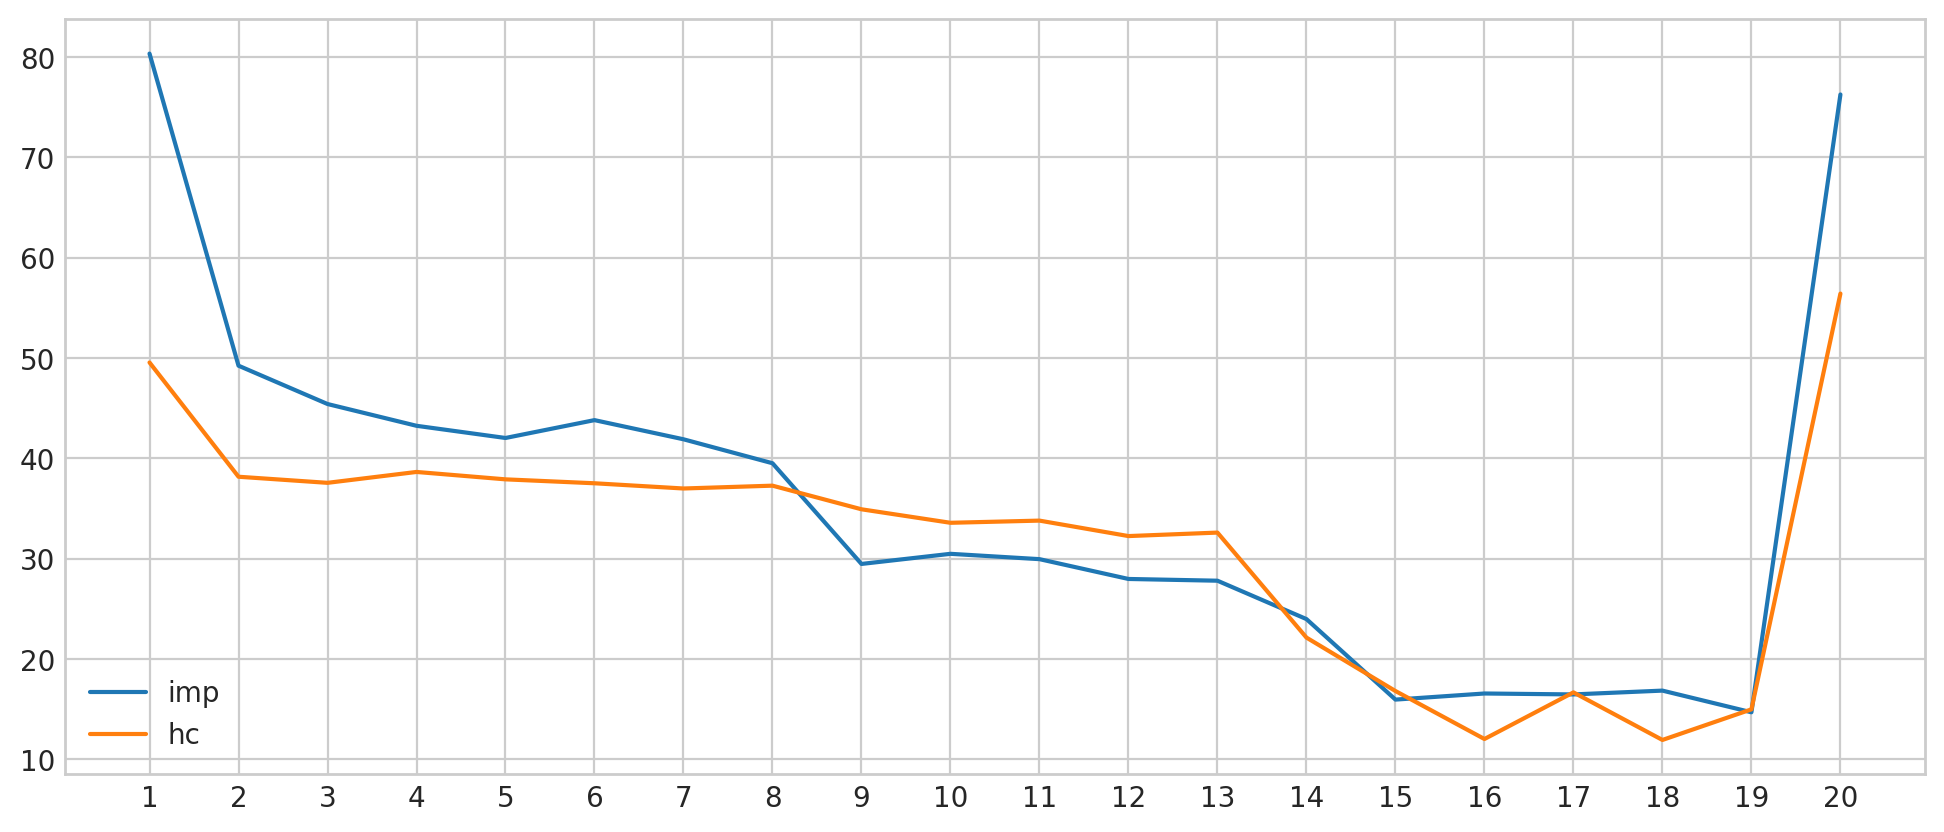

In [9]:
import matplotlib.pyplot as plt

layers_name = (np.arange(20) + 1).tolist()

plt.figure(figsize=(12, 5), dpi=200)
plt.plot(layers_name, imp_sparsity, label='imp')
plt.plot(layers_name, hc_sparsity, label='hc')
plt.xticks(layers_name)
plt.legend()
plt.show()


In [10]:
hc_sparsity

[49.53703703703704,
 38.151041666666664,
 37.54340277777778,
 38.62847222222222,
 37.890625,
 37.5,
 36.979166666666664,
 37.26128472222222,
 34.90668402777778,
 33.561197916666664,
 33.77821180555556,
 32.23741319444444,
 32.584635416666664,
 22.119140625,
 16.79416232638889,
 12.01171875,
 16.658528645833332,
 11.91677517361111,
 14.96853298611111,
 56.40625]

In [11]:
imp_sparsity

[80.32407407407408,
 49.21875,
 45.39930555555556,
 43.229166666666664,
 42.013888888888886,
 43.79340277777778,
 41.88368055555556,
 39.49652777777778,
 29.459635416666668,
 30.46875,
 29.93706597222222,
 27.962239583333332,
 27.78862847222222,
 23.963758680555557,
 15.93967013888889,
 16.54730902777778,
 16.455078125,
 16.834852430555557,
 14.67556423611111,
 76.25]